<a href="https://colab.research.google.com/github/CP2J/cp2j/blob/ACJ-11-opt1-RecSys_by_DL/MF_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝을 사용한 추천 시스템
< Reference : Python을 이용한 개인화 추천 시스템 2판 >

# 1. MF를 신경망으로 변환하기
- DL에 들어가기 전 은닉층이 없는 신경망 모형을 Keras로 구성해 보기로 한다.

<img src="https://drive.google.com/uc?id=1dmF6p0bNFDVpL9Un3J7Ja9A-0iF2Z1u0" alt="MF를 신경망으로 변환" height="300" width="400">

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거, 정수형 변환

In [3]:
ratings.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [4]:
# Train-test 분리 (이렇게 나누는 방법도 있군)
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75                         # 0.75 : 0.25
ratings = shuffle(ratings)                # row를 섞는다.
cutoff = int(TRAIN_SIZE * len(ratings))   # 끊는 지점
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [6]:
# Variable 초기화
K = 200                                 # Latent factor(잠재요인) 수
mu = ratings_train.rating.mean()        # 전체 평균
M = ratings.user_id.max() +1            # 사용자 아이디 최대값+1 : Number of users로 간주, 추후 Embedding에 사용
# 사용자 아이디는 1부터 943이지만(위 describe 참고)
# adding 1 ensures that all user IDs from 0 to the maximum ID are included in the embedding layer. 
N = ratings.movie_id.max() +1           # Number of movies

# RMSE 정의
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

<img src="https://drive.google.com/uc?id=1t-SuODMgtulPkinttPOTs4HW3cr4jpEj" alt="최종 MF 신경망 모델" height="300" width="400">

<img src="https://drive.google.com/uc?id=1qOscXw43A0VPdNuoz3IVX8pIvAGea28n" alt="최종 MF 신경망 모델" height="300" width="400">

* 사용자(아이템)에 대한 입력은 M(사용자 수) X M(feature, dummy variable) 차원의 One-hot Representation이다. 이는 위 그림처럼 해당 유저의 row는 그 유저 번호에 해당하는 dummy feature만 1이고 나머지는 0인 형태로 서로 다른 사용자를 구분해주는 encoding이다.

In [7]:
# Keras model
user = Input(shape=(1, ))                                             # 사용자 데이터 입력 형식 지정(id만 받음)
item = Input(shape=(1, ))                                             # 아이템 데이터 입력 형식 지정(id만 받음)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)      # 사용자 Embedding layer 지정 (M, 1, K) : (M X K)의 연결을 가진다.
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)      # 아이템 Embedding layer 지정 (N, 1, K) : (N X K)의 연결을 가진다.
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)        # User bias term (M, 1, ) : (M X 1)의 연결
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)        # Item bias term (N, 1, ) : (N X 1)의 연결

R = layers.dot([P_embedding, Q_embedding], axes=2)                    # (1, 1, 1)
# 유저 임베딩과 아이템 임베딩의 내적을 계산해 예측평점을 만드는 레이어( R = Dot(axes=2)([P_embedding, Q_embedding]) 도 가능 )

R = layers.add([R, user_bias, item_bias])
# 사용자 bias와 아이템 bias를 더한다.(R = Add()([R, user_bias, item_bias])도 가능)

R = Flatten()(R)                                                      # (1,1)
# 차원을 압축(1차원 배열로 변경)

# Model setting
model = Model(inputs=[user,item], outputs=R)                          # 모델 입출력 정의
model.compile(                                                        # 모델 컴파일 조건
    loss = RMSE,
    optimizer = SGD(),
    #optimizer = Adamax(),
    metrics = [RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

* embedding_4, 5(실행마다 번호는 다름)는 각각 사용자와 아이템의 잠재요인, 즉 P, Q를 나타냄
* 현재 train set에서 사용자(M) 944, 아이템(N) 1,683 이고, 각 사용자, 아이템에 대해서 K=200의 잠재요인을 지정했기 때문에 총 연결(Parameter)은 아래와 같다.
  * 사용자의 경우 944 * 200 = 188,800
  * 아이템의 경우 1,683 * 200 = 336,600
* embedding_6, 7은 bias layer로 사용자와 아이템 하나에 대해서 1개씩의 연결이 생기기 때문에 각각 944, 1683개의 연결(Parameter)이 만들어진다.

In [8]:
# Model fitting (위에서 구성한 신경망을 학습시킨다)
result = model.fit(
    x = [ratings_train.user_id.values, ratings_train.movie_id.values],
    # train set의 입력(독립변수) 지정. 입력은 각 사용자와 아이템 구분용 One-hot encoding을 위한 id
    y = ratings_train.rating.values - mu,
    # train set의 출력(종속변수) 지정.
    # 신경망 구성의 용이성을 위해 '평점값에서 전체적 경향성을 고려하기 위한 전체 평균을 뺀 값'을 쓰고,
    # 나중에 예측값에서 다시 더해줄 예정

    epochs = 60,                              # 반복횟수
    batch_size = 256,                         # 한번에 학습하는 batch 크기를 지정
    validation_data=(                         #정확도 측정을 위한 test set 지정
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/60
293/293 [==============================] - 8s 5ms/step - loss: 5.2708 - RMSE: 1.1260 - val_loss: 5.0302 - val_RMSE: 1.1245
Epoch 2/60
293/293 [==============================] - 1s 4ms/step - loss: 4.8102 - RMSE: 1.1239 - val_loss: 4.5963 - val_RMSE: 1.1225
Epoch 3/60
293/293 [==============================] - 1s 4ms/step - loss: 4.4005 - RMSE: 1.1218 - val_loss: 4.2104 - val_RMSE: 1.1208
Epoch 4/60
293/293 [==============================] - 1s 4ms/step - loss: 4.0361 - RMSE: 1.1199 - val_loss: 3.8673 - val_RMSE: 1.1191
Epoch 5/60
293/293 [==============================] - 1s 4ms/step - loss: 3.7125 - RMSE: 1.1185 - val_loss: 3.5621 - val_RMSE: 1.1176
Epoch 6/60
293/293 [==============================] - 2s 6ms/step - loss: 3.4243 - RMSE: 1.1169 - val_loss: 3.2907 - val_RMSE: 1.1161
Epoch 7/60
293/293 [==============================] - 2s 5ms/step - loss: 3.1681 - RMSE: 1.1154 - val_loss: 3.0494 - val_RMSE: 1.1148
Epoch 8/60
293/293 [==============================] - 1s 4ms/s

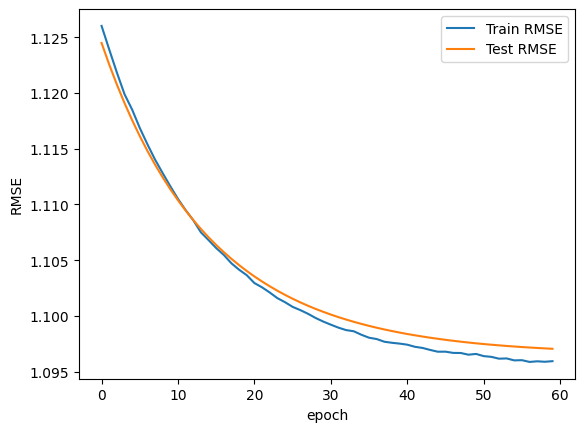

In [9]:
# 학습과정에서 측정지표의 변화
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [10]:
# Prediction (학습을 마친 신경망으로 예측을 수행)
user_ids = ratings_test.user_id.values[0:6]
movie_ids= ratings_test.movie_id.values[0:6]                # 예측 대상을 테스트셋 처음 6개로 정함
predictions = model.predict([user_ids, movie_ids]) + mu     # 예측치를 구한 후 학습시 빼준 전체평균을 다시 더해줌
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 96ms/step
Actuals: 
        user_id  movie_id  rating
24712       65       255       3
79098      889       144       4
33190       90       443       4
45489      658       724       3
11918      203        24       4
1196        13       147       3

Predictions: 
 [[3.534406 ]
 [3.5473406]
 [3.6341217]
 [3.5377514]
 [3.5247507]
 [3.4362838]]


* 꽤 차이가 있지만 경향성만은 비슷한 것 같다...

In [11]:
# 신경망에서 예측한 결과의 실제 RMSE 계산
def RMSE2(y_true, y_pred):
    return np.sqrt( np.mean( ( np.array(y_true) - np.array(y_pred) )**2 ) )

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
# Keras의 Model 클래스에서 제공하는 predict() 메소드는 신경망에 입력을 넣어주면 해당 신경망을 적용한 예측값을 계산해준다.
y_pred = np.ravel(y_pred, order = 'C')
# predict()로 얻은 예측값은 2차원(N X 1)의 array로 되어있으므로 np.ravel을 사용, 1차원 array로 바꿔준다.
y_true = np.array(ratings_test.rating)
# 실제 평점값을 가져온다.
RMSE2(y_true, y_pred)

782/782 [==============================] - 1s 2ms/step


1.0978791752384274